# Anomaly detection in time-series data using MXNet and NAB dataset

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import mxnet as mx
from mxnet import nd, autograd, gluon

from sklearn import preprocessing
from sklearn.metrics import f1_score

nab_path = './NAB'

In [2]:
nab_data_path = nab_path + '/data/'

## Load labels from NAB dataset

In [3]:
labels_file = open(nab_path + '/labels/combined_labels.json', 'r')
labels = json.loads(labels_file.read())
labels_file.close()

# TODO make it pretty
print(labels)

{'artificialNoAnomaly/art_daily_no_noise.csv': [], 'artificialNoAnomaly/art_daily_perfect_square_wave.csv': [], 'artificialNoAnomaly/art_daily_small_noise.csv': [], 'artificialNoAnomaly/art_flatline.csv': [], 'artificialNoAnomaly/art_noisy.csv': [], 'artificialWithAnomaly/art_daily_flatmiddle.csv': ['2014-04-11 00:00:00'], 'artificialWithAnomaly/art_daily_jumpsdown.csv': ['2014-04-11 09:00:00'], 'artificialWithAnomaly/art_daily_jumpsup.csv': ['2014-04-11 09:00:00'], 'artificialWithAnomaly/art_daily_nojump.csv': ['2014-04-11 09:00:00'], 'artificialWithAnomaly/art_increase_spike_density.csv': ['2014-04-07 23:10:00'], 'artificialWithAnomaly/art_load_balancer_spikes.csv': ['2014-04-11 04:35:00'], 'realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv': ['2014-02-26 22:05:00', '2014-02-27 17:15:00'], 'realAWSCloudwatch/ec2_cpu_utilization_53ea38.csv': ['2014-02-19 19:10:00', '2014-02-23 20:05:00'], 'realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv': ['2014-02-19 00:22:00', '2014-02-24 18:37:00']

## Load Training Data

We take real AWS Cloudwatch data from some RDS instance for the study. Adding information on labled anomalies we have right from the start for visibility. 

In [4]:
def load_data_frame_with_labels(file_name):
    data_frame = pd.read_csv(nab_data_path + file_name)
    data_frame['anomaly_label'] = data_frame['timestamp'].isin(labels[file_name]).astype(int)
    return data_frame

training_file_name = 'realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv'

training_data_frame = load_data_frame_with_labels(training_file_name)
training_data_frame.shape

(4032, 3)

In [5]:
training_data_frame.head()

,timestamp,value,anomaly_label
0,2014-04-10 00:02:00,14.012,0
1,2014-04-10 00:07:00,13.334,0
2,2014-04-10 00:12:00,15.000,0
3,2014-04-10 00:17:00,13.998,0
4,2014-04-10 00:22:00,14.332,0


## Load Test Data

There is another file with real AWS Cloudwatch data from some RDS instance. It has also labeled anomalies. We will use it as a Test dataset at the end to calculate F1 score.

In [6]:
test_file_name = 'realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv'

test_data_frame = load_data_frame_with_labels(test_file_name)
test_data_frame.shape

(4032, 3)

In [7]:
test_data_frame.head()

,timestamp,value,anomaly_label
0,2014-02-14 14:30:00,6.456,0
1,2014-02-14 14:35:00,5.816,0
2,2014-02-14 14:40:00,6.268,0
3,2014-02-14 14:45:00,5.816,0
4,2014-02-14 14:50:00,5.862,0


## Plotting training and test data

In [8]:
def convert_timestamps(data_frame):
    data_frame['timestamp'] = pd.to_datetime(data_frame['timestamp'])
    data_frame['time_epoch'] = data_frame['timestamp'].astype(np.int64)


convert_timestamps(training_data_frame)
convert_timestamps(test_data_frame)

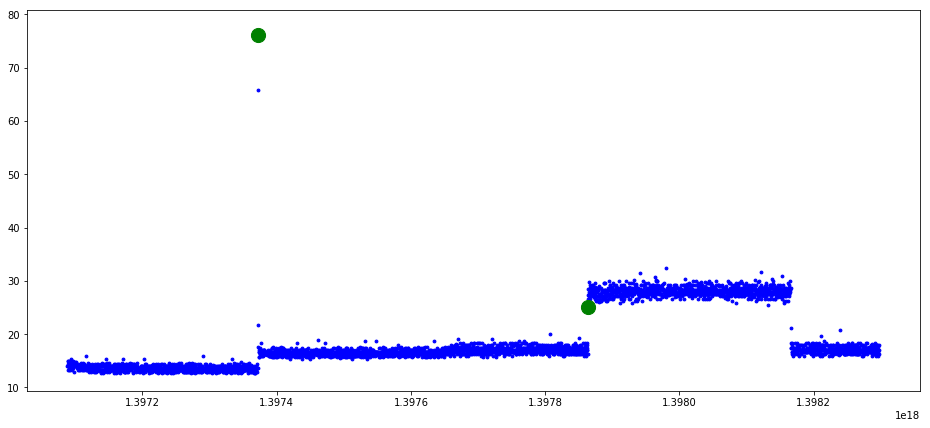

In [9]:
def prepare_plot(data_frame):
    fig, ax = plt.subplots()
    ax.scatter(data_frame['time_epoch'], data_frame['value'], s=8, color='blue')

    labled_anomalies = data_frame.loc[data_frame['anomaly_label'] == 1, ['time_epoch', 'value']]
    ax.scatter(labled_anomalies['time_epoch'], labled_anomalies['value'], s=200, color='green')
    
    return ax


figsize(16, 7)
prepare_plot(training_data_frame)
plt.show()

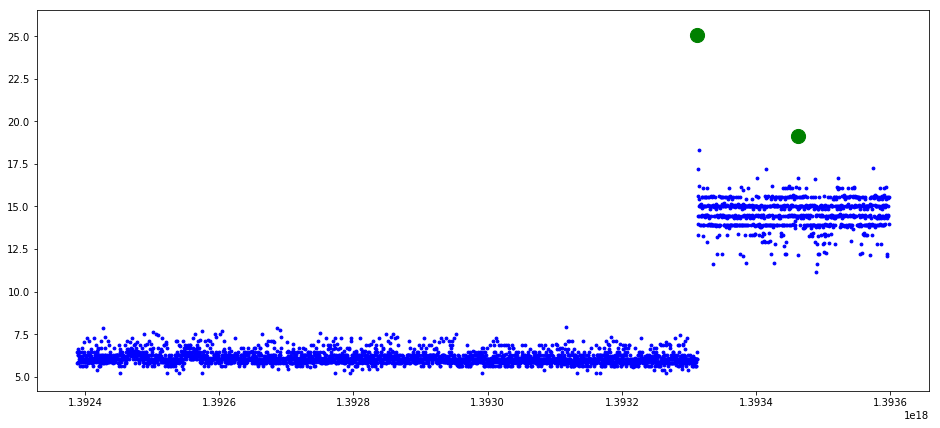

In [10]:
figsize(16, 7)
prepare_plot(test_data_frame)
plt.show()

## Scale the train data

TODO
- Add more details in scaling importance
- review results depending on scaling
- (optionally) review results depending on smoothing of anomalies, if this is not Captain Obvious

In [11]:
features = ['value']
feature_count = len(features)

data_scaler = preprocessing.StandardScaler()

training_data = data_scaler.fit_transform(
    training_data_frame[features].values.astype(np.float32)
)

## Prepare training and validation data

TODO 3 options
- training with anomalies, validation without anomalies
- training with anomalies, validation with anomalies
- training without anomalies, validation with anomalies

In [12]:
rows = len(training_data)

split_factor = 0.8

training = training_data[0:int(rows * split_factor)]
validation = training_data[int(rows * split_factor):]

## Choosing a model

We focus on LSTM NN for this case.

In [13]:
model = mx.gluon.nn.Sequential()
with model.name_scope():
    model.add(mx.gluon.rnn.LSTM(feature_count))
    model.add(mx.gluon.nn.Dense(feature_count, activation='tanh'))

## Training process

In [14]:
L = gluon.loss.L2Loss()


def evaluate_accuracy(data_iterator, model, L):
    loss_avg = 0.
    for i, data in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1, 1, feature_count))
        output = model(data)
        loss = L(output, data)
        loss_avg = (loss_avg * i + nd.mean(loss).asscalar()) / (i + 1)
    return loss_avg

In [15]:
ctx = mx.cpu()


epochs = 15
batch_size = 6


training_data_batches = mx.gluon.data.DataLoader(training, batch_size, shuffle=False)
validation_data_batches = mx.gluon.data.DataLoader(validation, batch_size, shuffle=False)


training_mse = []
validation_mse = []


model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)


trainer = gluon.Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.01})


for epoch in range(epochs):
    print(str(epoch+1))
    for i, data in enumerate(training_data_batches):
        data = data.as_in_context(ctx).reshape((-1, 1, feature_count))

        with autograd.record():
            output = model(data)
            loss = L(output, data)

        loss.backward()
        trainer.step(batch_size)

    training_mse.append(evaluate_accuracy(training_data_batches, model, L))
    validation_mse.append(evaluate_accuracy(validation_data_batches, model, L))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


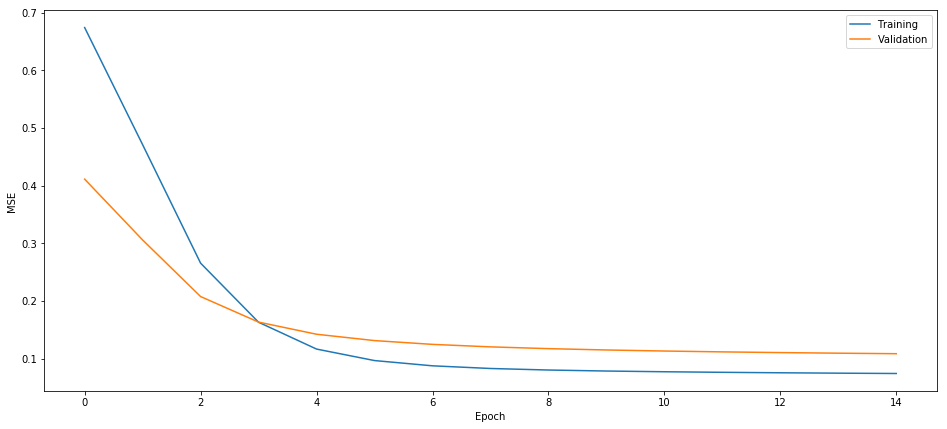

In [16]:
def plot_errors(train_mse, validate_mse):
    epochs = range(len(train_mse))
    plt.plot(epochs, train_mse, label='Training')
    plt.plot(epochs, validate_mse, label='Validation')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


figsize(16, 7)
plot_errors(training_mse, validation_mse)

## Checking predicitons on test data

In [17]:
def calculate_reconstruction_errors(input_data, L):
    reconstruction_errors = []
    for i, data in enumerate(input_data):
        input = data.as_in_context(ctx).reshape((-1, feature_count, 1))
        predicted_value = model(input)
        reconstruction_error = L(predicted_value, input).asnumpy().flatten()        
        reconstruction_errors = np.append(reconstruction_errors, reconstruction_error)

    return reconstruction_errors

In [18]:
all_training_data = mx.gluon.data.DataLoader(
    training_data.astype(np.float32), batch_size, shuffle=False)

training_reconstruction_errors = calculate_reconstruction_errors(all_training_data, L)
reconstruction_error_threshold = np.mean(training_reconstruction_errors) + 3 * \
                                 np.std(training_reconstruction_errors)

In [19]:
test_data = data_scaler.fit_transform(
    test_data_frame[features].values.astype(np.float32)
)

test_data_batches = mx.gluon.data.DataLoader(test_data, batch_size, shuffle=False)

test_reconstruction_errors = calculate_reconstruction_errors(test_data_batches, L)

predicted_test_anomalies = list(
    map(lambda v: 1 if v > reconstruction_error_threshold else 0, test_reconstruction_errors)
)

test_data_frame['anomaly_predicted'] = predicted_test_anomalies

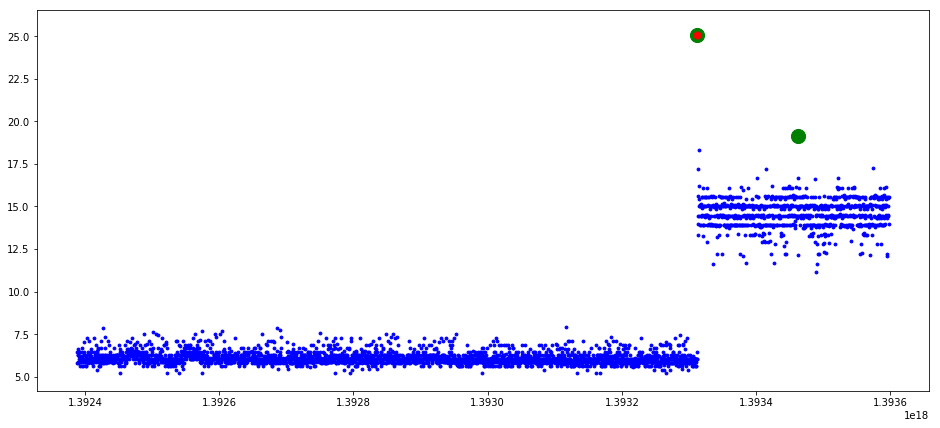

In [20]:
figsize(16, 7)

ax = prepare_plot(test_data_frame)

predicted_anomalies = test_data_frame.loc[test_data_frame['anomaly_predicted'] == 1, ['time_epoch', 'value']]
ax.scatter(predicted_anomalies['time_epoch'], predicted_anomalies['value'], s=50, color='red')

plt.show()

## F1 score calculation

In [21]:
test_labels = test_data_frame['anomaly_label'].astype(np.float32)

score = f1_score(test_labels, predicted_test_anomalies)
print('F1 score: ' + str(score))

F1 score: 0.6666666666666666
